# Gene Expression Classification and Model Interpretation by LIME

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
from numpy import array
from numpy import argmax
from keras.utils import to_categorical
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import sys
from numpy import load
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.models import Model
from tensorflow.keras import regularizers
from keras.applications.inception_v3 import InceptionV3, preprocess_input

In [ ]:
df=pd.read_csv("/90days/s4634945/files/UntitledFolder/CNN_dataframe_gene_expression_3.csv")
df_test=pd.read_csv("/90days/s4634945/files/UntitledFolder/CNN_dataframe_gene_expression_test_3.csv")
df['Cluster'] = df['Cluster'].astype('str')
df_test['Cluster']= df_test['Cluster'].astype('str')
datagen=ImageDataGenerator(rescale=1./255, validation_split = 0.2, featurewise_center=True,
            featurewise_std_normalization=False,
            rotation_range=90,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255,featurewise_center=True)
train_generator=datagen.flow_from_dataframe(dataframe=df, directory="/90days/s4634945/files/UntitledFolder/Trainimg_breast_2_299", x_col="Image", y_col="Cluster", class_mode="categorical", target_size=(290,290), batch_size=32, shuffle = True, subset="training")
valid_generator = datagen.flow_from_dataframe(dataframe=df, directory="/90days/s4634945/files/UntitledFolder/Trainimg_breast_2_299", x_col="Image", y_col="Cluster", class_mode="categorical", target_size=(290,290), batch_size=32, shuffle = True, subset="validation")
test_generator = test_datagen.flow_from_dataframe(dataframe=df_test, directory="/90days/s4634945/files/UntitledFolder/Trainimg_breast_test_299", x_col="Image", y_col="Cluster", class_mode="categorical", target_size=(290,290), batch_size=32, shuffle = True)


In [ ]:
model = InceptionV3(include_top=False, input_shape=(290,290,3), weights = "imagenet")
for layer in model.layers:
        layer.trainable = False
flat1 = Flatten()(model.layers[-1].output)
dense = Dense(256, activation='relu')(flat1)
drop = Dropout(0.35)(dense)
output = Dense(3, activation='softmax')(drop)
model = Model(inputs=model.inputs, outputs=output)


#history = model.fit(train_generator,validation_data=valid_generator,epochs=25)
'''
model = Sequential([
    
    # First convolution
        Conv2D(16, (3,3), activation='relu', input_shape=(290,290, 3), kernel_regularizer=regularizers.l2(0.02)),
        #Conv2D(16, (3,3), activation='relu'),
        MaxPooling2D(2, 2),
    
    # Second convolution
        Conv2D(32, (3,3), activation='relu'),
        #Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),
    
    # Third convolution
        Conv2D(64, (3,3), activation='relu'),
        #Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),

    
    # Fourth convolution
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
    
    # Dense hidden layer
        Dense(64, activation='relu'),
        Dropout(0.5),
 
    # Output neuron. 
        Dense(2, activation='softmax') 
])'''

opt = Adam(learning_rate=0.000001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['AUC'])

history = model.fit(train_generator,validation_data=valid_generator,epochs=10)

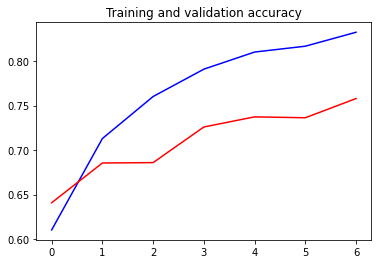

In [9]:
import matplotlib.pyplot as plt
def plot_training(history):
    acc = history.history['auc']
    val_acc = history.history['val_auc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    plt.show()
    
plot_training(history)

In [ ]:
from keras.models import model_from_json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

# Test Set

In [10]:
print(model.evaluate(test_generator))
#from skimage import io
from tensorflow.keras.preprocessing import image
import cv2
import glob
preds = model.predict(test_generator)
test_pred = np.argmax(preds, axis=1)
#print(test_pred)
unique, counts = np.unique(test_pred, return_counts=True)
print(counts)

125/125 [==============================] - 842s 7s/step - loss: 0.8479 - auc: 0.7917
[0.847913920879364, 0.7916553616523743]
[ 986 2383  618]


In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
def multiclass_roc_auc_score(truth, pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)

cm = confusion_matrix(df_test['Cluster'].astype('int64'), test_pred)
print('Confusion matrix\n\n', cm)
classifier_report = classification_report(df_test['Cluster'].astype('int64'), test_pred)
print(classifier_report)
multiclass_roc_score = multiclass_roc_auc_score(df_test['Cluster'].astype('int64'), test_pred, average="weighted")
print("Multiclass_roc_score")
print(multiclass_roc_score)
#logloss = log_loss(df_test['Cluster'].astype('int64'), test_pred)
#print(log_loss)

Confusion matrix

 [[ 252  599  151]
 [ 482 1188  320]
 [ 252  596  147]]
              precision    recall  f1-score   support

           0       0.26      0.25      0.25      1002
           1       0.50      0.60      0.54      1990
           2       0.24      0.15      0.18       995

    accuracy                           0.40      3987
   macro avg       0.33      0.33      0.33      3987
weighted avg       0.37      0.40      0.38      3987

Multiclass_roc_score
0.4991432350527331


# LIME

In [19]:
explanation.local_exp[explanation.top_labels[2]]

[(77, -3.3391873883061847e-32),
 (248, -3.223715625155477e-32),
 (215, -3.1445967967055575e-32),
 (14, -3.1013277818320473e-32),
 (109, -3.001028790309835e-32),
 (93, 2.935660464547111e-32),
 (45, -2.93118988018221e-32),
 (88, 2.795598280641205e-32),
 (26, -2.718501598131407e-32),
 (185, 2.587613937705107e-32),
 (57, 2.566324705386746e-32),
 (103, 2.561198715060155e-32),
 (195, 2.505833351697385e-32),
 (157, -2.500116317939226e-32),
 (227, -2.4827923680433904e-32),
 (108, -2.47194927605848e-32),
 (49, -2.440049024845275e-32),
 (143, -2.4149213972489807e-32),
 (86, 2.4084820217928138e-32),
 (252, 2.3509924510246315e-32),
 (120, 2.326589489939085e-32),
 (138, -2.2578589412577463e-32),
 (121, -2.2529448593018456e-32),
 (84, -2.2520689444479418e-32),
 (137, -2.24203854269481e-32),
 (23, -2.2327844262223884e-32),
 (43, 2.229157049780737e-32),
 (139, -2.201600402923687e-32),
 (96, -2.1993126024484754e-32),
 (35, -2.1643464850689137e-32),
 (179, 2.1527148662940851e-32),
 (203, 2.1478320986150

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


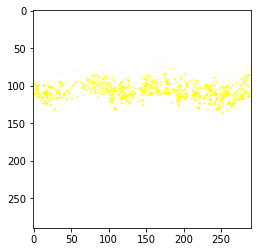

In [13]:
from lime import lime_image
import cv2
img=cv2.imread('/90days/s4634945/files/UntitledFolder/Trainimg_breast_2_299/1000img.tif')
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img.astype('double'), model.predict)
from skimage.segmentation import mark_boundaries
#temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, num_features=100, hide_rest=False)
#plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


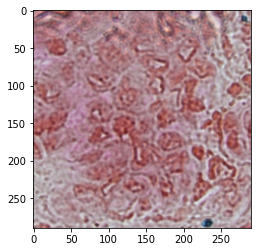

In [23]:
plt.imshow(img)

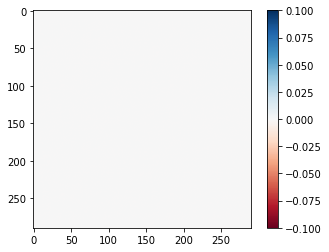

In [22]:
ind =  explanation.top_labels[0]
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

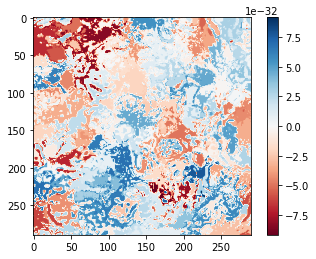

In [20]:
ind =  explanation.top_labels[1]
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

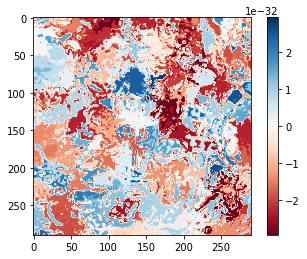

In [21]:
ind =  explanation.top_labels[2]
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

# Eli5